In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
INPUT_FILE = "../../test_data/system_tests/diaPASEF_diann/report.tsv.top3added.tsv"

DIRECTLFQ_FILE_PRECURSORS_MS1_MS2 = "../../test_data/system_tests/diaPASEF_diann/report.tsv.top3added.tsv.diann_precursor_ms1_and_ms2.protein_intensities.tsv"
DIRECTLFQ_FILE_PRECURSORS = "../../test_data/system_tests/diaPASEF_diann/report.tsv.top3added.tsv.diann_precursors.protein_intensities.tsv"
DIRECTLFQ_FILE_FRAGIONS = "../../test_data/system_tests/diaPASEF_diann/report.tsv.top3added.tsv.diann_precursor_ms1_and_ms2.protein_intensities.tsv"


SAMPLEMAP  = "../../test_data/system_tests/diaPASEF_diann/samplemap.tsv"

In [3]:
import alphabase.test_data_downloader as tdd

tdd.DataShareDownloader(url="https://datashare.biochem.mpg.de/s/9UoHMjTCJ8TmmlA", output_dir="../../test_data/system_tests/").download()

../../test_data/system_tests/diaPASEF_diann already exists


'../../test_data/system_tests/diaPASEF_diann'

In [ ]:
import directlfq.lfq_manager as lfqmgr
input_types_to_use  = ["diann_fragion_isotopes_topn", "diann_precursor_ms1_and_ms2", "diann_precursors", "diann_fragion_isotopes"]
for input_type in input_types_to_use:
	lfqmgr.run_lfq(input_file=INPUT_FILE, input_type_to_use=input_type)

In [7]:
import directlfq.benchmarking as lfqbenchmark
import directlfq.utils as lfqutils


samples_used = lfqutils.get_samples_used_from_samplemap_file(SAMPLEMAP, cond1="45ng", cond2="15ng")


restable_directlfq_ms1_and_ms2 = lfqbenchmark.ResultsTableDirectLFQ(input_file=DIRECTLFQ_FILE_PRECURSORS_MS1_MS2, input_name="directLFQ", samples_c1=samples_used[0], samples_c2=samples_used[1])
restable_directlfq_precursors = lfqbenchmark.ResultsTableDirectLFQ(input_file=DIRECTLFQ_FILE_PRECURSORS, input_name="directLFQ", samples_c1=samples_used[0], samples_c2=samples_used[1])
restable_directlfq_fragions = lfqbenchmark.ResultsTableDirectLFQ(input_file=DIRECTLFQ_FILE_FRAGIONS, input_name="directLFQ", samples_c1=samples_used[0], samples_c2=samples_used[1])


restables = [restable_directlfq_ms1_and_ms2, restable_directlfq_precursors, restable_directlfq_fragions]
restable_names = ["directLFQ (precursors, MS1+MS2)", "directLFQ (precursors)", "directLFQ (fragions)"]

organism_annotator_diann = lfqbenchmark.OrganismAnnotatorDIANN(mapping_file=INPUT_FILE)
for restable in restables:
    organism_annotator_diann.annotate_table_with_organism(restable)
    

methodname2formatted_df = {'directLFQ_precursor_ms1_and_ms2' : restable_directlfq_ms1_and_ms2.formated_dataframe, 'directLFQ_precursor' : restable_directlfq_precursors.formated_dataframe,
                        'directLFQ_fragions' : restable_directlfq_fragions.formated_dataframe}

/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:144: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:144: RuntimeWarning: invalid value encountered in scalar subtract
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:144: RuntimeWarning: divide by zero encountered in log2
  self.formated_dataframe[self.log2fc_column] = [np.log2(x[0]) - np.log2(x[1]) for x in zip(self.formated_dataframe['median_intensity_c1'], self.formated_dataframe['median_intensity_c2'])]
/Users/constantin/workspace/directlfq/directlfq/benchmarking.py

In [15]:
import numpy as np
import directlfq.test_utils as testutils

organism2expectedfc={"YEAST" : np.log2(3), "HUMAN" : 0}
organism2CI95={"YEAST" : 0.93, "HUMAN" : 0.3}

for method, formatted_df in methodname2formatted_df.items():
	testutils.RatioChecker(formatted_df=formatted_df, organism2expectedfc=organism2expectedfc, organism2CI95=organism2CI95)
	print(f"Method {method} passed the test")
	



2024-10-14 13:10:52,618 - directlfq.test_utils - INFO - Checked ratios, no bias detected
2024-10-14 13:10:52,626 - directlfq.test_utils - INFO - Checked ratios, no bias detected
2024-10-14 13:10:52,632 - directlfq.test_utils - INFO - Checked ratios, no bias detected
2024-10-14 13:10:52,640 - directlfq.test_utils - INFO - Checked ratios, no bias detected
2024-10-14 13:10:52,647 - directlfq.test_utils - INFO - Checked ratios, no bias detected
2024-10-14 13:10:52,654 - directlfq.test_utils - INFO - Checked ratios, no bias detected


Method directLFQ_precursor_ms1_and_ms2 passed the test
Method directLFQ_precursor passed the test
Method directLFQ_fragions passed the test


2024-10-14 13:09:55,483 - directlfq.visualizations - INFO - YEAST num:3097 median_FC:1.4 STD:0.32

2024-10-14 13:09:55,486 - directlfq.visualizations - INFO - HUMAN num:8571 median_FC:-0.025 STD:0.1

/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
2024-10-14 13:09:55,535 - directlfq.visualizations - INFO - YEAST num:3097 median_FC:1.4 STD:0.33

2024-10-14 13:09:55,538 - directlfq.visualizations - INFO - HUMAN num:8571 median_FC:-0.025 STD:0.11

/Users/constantin/opt/anaconda3/envs/directlfq/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
2024-10-14 13:09:55,585 - directlfq.visualizations - INFO - YEAST num:3097 median_FC:1.4 STD:0.32

2024-10-14 13:09:55,589 - directlfq.visualizations - INFO - HUMAN num:8571 median_

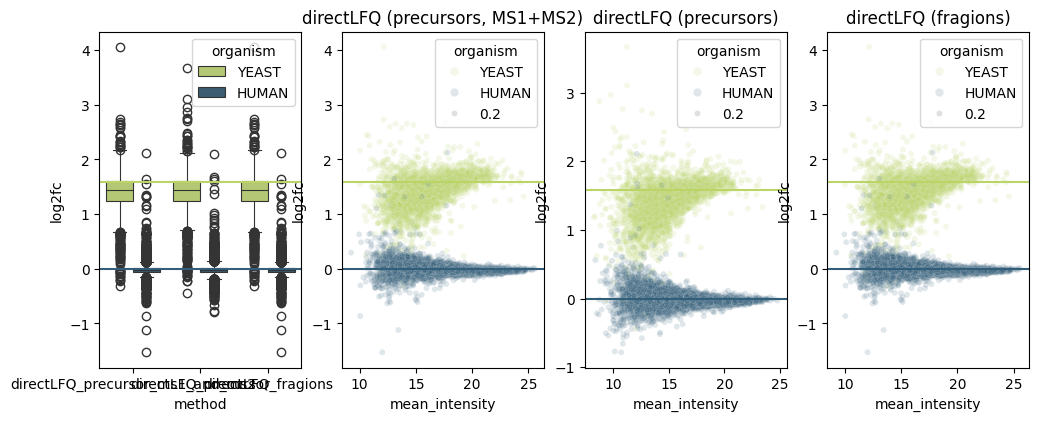

In [12]:
import seaborn as sns
import directlfq.visualizations
import directlfq.benchmarking
import matplotlib.pyplot as plt
import numpy as np


class MultiOrganismMultiMethodBoxPlotAdapted(directlfq.visualizations.MultiOrganismMultiMethodBoxPlot):
    def plot_boxplot(self):
        color_palette = sns.color_palette(self._colorlist_hex, n_colors=len(self._fcs_to_expect))
        sns.boxplot(data=self._method_ratio_results_table, x="method", y = "log2fc", hue= "organism", palette=color_palette, hue_order=self._organisms_to_plot, ax=self.ax, linewidth=0.8)




num_results = len(restables)

fig, axes = plt.subplots(1, num_results+1,figsize=(4*num_results, 4.363))

organisms_to_plot = [ "YEAST", "HUMAN"]
fcs_to_expect = [  np.log2(3), 0]

merged_table = directlfq.benchmarking.ResultsTableMerger(method_name2results_df=methodname2formatted_df).merged_table


MultiOrganismMultiMethodBoxPlotAdapted(method_ratio_results_table=merged_table, ax = axes[0], organisms_to_plot=organisms_to_plot,fcs_to_expect= fcs_to_expect)


for idx in range(num_results):
    restable = restables[idx]
    name = restable_names[idx]
    ax = axes[idx+1]
    directlfq.visualizations.MultiOrganismIntensityFCPlotter(ax=ax, resultstable_w_ratios=restable, organisms_to_plot = organisms_to_plot, fcs_to_expect= fcs_to_expect, title=name)

